# Make MLZ input catalog of [1-1], [2-1], and [1-2] groups from fof matching.
Editted by HyeYun Park, adding MLZ catalog making to 'matching_fof.ipynb' <br>
(Match truth and coadd catalogs for DC2 Run 1.1p : Owner: Yao-Yuan Mao, Scott Daniel (with help from Anže Slosar, Bhairav Valera, HyeYun Park)) <br>

**Notes:**
- Follow this [step-by-step guide](https://confluence.slac.stanford.edu/x/Xgg4Dg) if you don't know how to run this notebook.
- If you need more information about the Generic Catalog Reader (GCR), see [this diagram](https://github.com/yymao/generic-catalog-reader/blob/master/README.md#concept) and [more examples](https://github.com/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
import GCRCatalogs

In [ ]:
GCRCatalogs.available_catalogs

In [4]:
# load coadd catalog (for a single tract)
coadd_cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')

In [ ]:
coadd_cat.list_all_quantities()

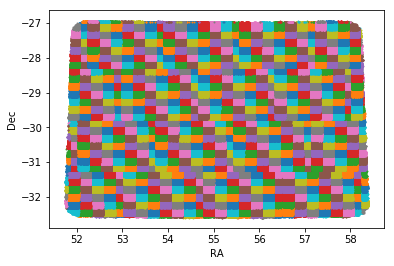

In [5]:
# Let's first visually inspect the footprint of one tract of the coadd catalog.
# When `return_iterator` is turned on, the method `get_quantities` will return an 
# iterator, and each element in the iterator will be the quantities we requested in 
# different chunks of the dataset. 

# For coadd catalogs, the different chunks happen to be different patches, 
# resulting in a different color for each patch in the scatter plot below.

for coadd_data in coadd_cat.get_quantities(['ra', 'dec'], return_iterator=True):
    plt.scatter(coadd_data['ra'], coadd_data['dec'], s=1, rasterized=True);

plt.xlabel('RA');
plt.ylabel('Dec');

In [6]:
# Let's choose a small RA and Dec range to do the matching so that it won't take too long!
ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

In [7]:
# star, sprinkled, agn cuts for the truth catalog.
from GCR import GCRQuery
star_sprinkled_filter = [
    ~GCRQuery('star'),
    ~GCRQuery('sprinkled'),
    ~GCRQuery('agn')
]

In [8]:
# Lensing cuts based on Mandelbaum 2017 (arxiv 1705.06745)
lensing_cuts = [
    ~GCRQuery((np.isnan, 'i_modelfit_CModel_instFlux')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('i_SN_cmodel >= 10'),
    GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped'),
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('mag_i_cModel < 24.5'), # FIXME: Doesnt have exinction correction
    GCRQuery('base_Blendedness_abs_instFlux < 10**(-0.375)'),
]
#    GCRQuery('i_SN_cmodel >= 10'), # (from this and below) cut on object properties

In [9]:
# Let's also define a magnitude cut
mag_filters = [
    GCRQuery((np.isfinite, 'mag_i')),
    GCRQuery('mag_i < 25.5')
]

In [10]:
# let's add total ellipticity for later use (not needed for now)
coadd_cat.add_derived_quantity('shape_hsm_regauss_etot', np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2')

In [11]:
coadd_cat.add_quantity_modifier('i_SN_cmodel', 
                              (np.divide, 'i_modelfit_CModel_instFlux', 'i_modelfit_CModel_instFluxErr'), 
                              overwrite=True)
coadd_cat.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=False)
coadd_cat.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)
coadd_cat.add_quantity_modifier('psf_size', 
                              (lambda xx, yy, xy: 0.168*2.355*(xx*yy - xy*xy)**0.25, 'r_base_SdssShape_psf_xx', 'r_base_SdssShape_psf_yy', 'r_base_SdssShape_psf_xy'),
                              overwrite=True)

In [15]:
# Load ra and dec from coadd, using both of the filters we just defined. (why not also grab e1 and e2 for later use?)
coadd_data = coadd_cat.get_quantities(['ra', 'dec', 'objectId','mag_i_cModel','mag_u_cModel','mag_g_cModel','mag_r_cModel',
                                       'mag_y_cModel','mag_z_cModel',
                                       'magerr_i','magerr_u','magerr_g','magerr_r','magerr_y',
                                       'magerr_z','shape_hsm_regauss_etot','i_modelfit_CModel_instFlux',
                                      'ext_shapeHSM_HsmShapeRegauss_resolution',
                                      'ext_shapeHSM_HsmShapeRegauss_e1',
                                      'ext_shapeHSM_HsmShapeRegauss_e2',
                                      'deblend_skipped','base_PixelFlags_flag_edge',
                                      'base_PixelFlags_flag_interpolatedCenter',
                                      'base_PixelFlags_flag_saturatedCenter','base_PixelFlags_flag_crCenter',
                                      'base_PixelFlags_flag_bad','base_PixelFlags_flag_suspectCenter',
                                      'base_PixelFlags_flag_clipped','ext_shapeHSM_HsmShapeRegauss_flag',
                                      'i_SN_cmodel','detect_isPrimary','HSM_res',
                                      'HSM_ell','ext_shapeHSM_HsmShapeRegauss_sigma','mag_i_cModel',
                                      'base_Blendedness_abs_instFlux','mag_i'],filters=(mag_filters+lensing_cuts))#, filters=(coord_filters + mag_filters))

In [18]:
bin_cut = ~GCRQuery((np.isnan, 'i_modelfit_CModel_instFlux'),
                    (np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution'),
                    (np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1'),
                    (np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2'),
                    'deblend_skipped','base_PixelFlags_flag_edge',
                    'base_PixelFlags_flag_interpolatedCenter',
                    'base_PixelFlags_flag_saturatedCenter','base_PixelFlags_flag_crCenter',
                    'base_PixelFlags_flag_bad','base_PixelFlags_flag_suspectCenter',
                    'base_PixelFlags_flag_clipped','ext_shapeHSM_HsmShapeRegauss_flag').mask(coadd_data)
bin_cut2=GCRQuery('i_SN_cmodel >= 10','detect_isPrimary','HSM_res >= 0.3','HSM_ell < 2.0',
                  'ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4','mag_i_cModel < 24.5',
                  'base_Blendedness_abs_instFlux < 10**(-0.375)',(np.isfinite, 'mag_i'),
    'mag_i < 25.5').mask(coadd_data)

In [13]:
filters=(mag_filters+lensing_cuts)
mask = GCRQuery(*filters).mask(coadd_data)

In [16]:
assert len(coadd_data['ra']) == np.count_nonzero(mask)

In [17]:
print (len(coadd_data['ra']),np.count_nonzero(mask))

493408 493408


In [33]:
print (mask)

[False False False ... False False False]


In [21]:
print (sum(bin_cut2), sum(bin_cut))
bin_cut3 = np.logical_and(bin_cut, bin_cut2)
print (sum(bin_cut3))

513921 2840487
513921


In [23]:
print (len(coadd_data['ra']))

493408


In [85]:
# check number of objects in truth and coadd catalog with the cuts (filters) 
a=np.append(a,len(coadd_data['ra']))
print (len(coadd_data['ra']))
print (len(truth_data['ra']))
print (a)

1373094
8881781
[ 493408. 1327960. 1100454. 1100454. 1100454. 1025425. 1373094. 1373094.
 1350220. 1350049. 1350390. 1370610. 1373094. 1373094. 1317613. 1100454.
  708457.  989690.  748240.  942971. 1291990. 1373094.]


In [ ]:
b=np.arange(len(a11))+1
x_labels=['all','~i_modelfit_CModel_instFlux','~ext_shapeHSM_HsmShapeRegauss_resolution',
          '~ext_shapeHSM_HsmShapeRegauss_e1','~ext_shapeHSM_HsmShapeRegauss_e2','i_SN_cmodel >= 10',
          'detect_isPrimary','~deblend_skipped','~base_PixelFlags_flag_edge',
          '~base_PixelFlags_flag_interpolatedCenter','~base_PixelFlags_flag_saturatedCenter',
          '~base_PixelFlags_flag_crCenter','~base_PixelFlags_flag_bad',
          '~base_PixelFlags_flag_suspectCenter','~base_PixelFlags_flag_clipped',
          '~ext_shapeHSM_HsmShapeRegauss_flag','HSM_res >= 0.3','HSM_ell < 2.0',
          'ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4','mag_i_cModel < 24.5',
          'base_Blendedness_abs_instFlux < 10**(-0.375)','none']
fig,ax=plt.subplots(1,1, figsize=(10,8))
ax.scatter(b,a11, color='orange',marker='o',label='[1-1]')
ax.scatter(b,a21, color='green',marker='*', label='[2-1]')
#ax.scatter(b,a212)
ax.set_xticks(b)
ax.grid()
ax.legend()
ax.set_xticklabels(x_labels,rotation='vertical',fontsize=18)

In [18]:
# Let's now turn to the truth catalog, turn of md5 sum check to save time
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_static', {'md5': None})

In [14]:
# for a reason that we will soon see, let's inspect the quantities in truth catalog

print(sorted(truth_cat.list_all_quantities()))
print('---')
print(sorted(truth_cat.list_all_native_quantities()))

['agn', 'mag_true_g', 'mag_true_i', 'mag_true_r', 'mag_true_u', 'mag_true_y', 'mag_true_z', 'sprinkled', 'star']
---
['agn', 'dec', 'g', 'healpix_2048', 'i', 'object_id', 'r', 'ra', 'redshift', 'sprinkled', 'star', 'u', 'y', 'z']


In [19]:
# so we see there is not mag_i, but only mag_true_i (i.e., magnitude before lensing), and it maps to `i`
truth_cat.get_quantity_modifier('mag_true_i')

'i'

In [20]:
# to make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', 'i')

In [21]:
# get ra and dec from truth catalog
# note that we add i < 24.5 to the native filter to speed up load time
#truth_native_filters = (coord_filters + ['i < 24.5'])
truth_data = truth_cat.get_quantities(['ra', 'dec', 'object_id', 'star', 'sprinkled','agn','redshift','mag_true_i',
                                      'g','mag_true_g','mag_true_r', 'mag_true_u', 'mag_true_y', 'mag_true_z'],filters=star_sprinkled_filter)#, filters=mag_filters, native_filters=truth_native_filters)

# We will use the object_id, star, and sprinkled columns when cross-referencing truth information with the extragalactic catalog.

In [22]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'coadd': coadd_data},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [ ]:
# return of FoFCatalogMatching.match is an astropy table
results

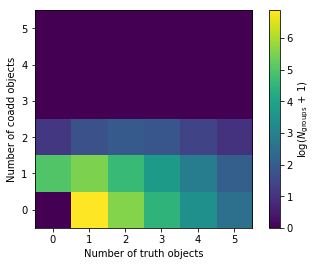

In [23]:
# now we want to count the number of truth and coadd objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the coadd
truth_mask = results['catalog_key'] == 'truth'
coadd_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_coadd = np.bincount(results['group_id'][coadd_mask], minlength=n_groups)

# now n_truth and n_coadd are the number of truth/coadd objects in each group
# we want to make a 2d histrogram of (n_truth, n_coadd). 
n_max = max(n_truth.max(), n_coadd.max()) + 1
hist_2d = np.bincount(n_coadd * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of coadd objects');
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [24]:
# Let's further inspect the objects in the groups that have 1-to-1 truth/coadd match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/coadd match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_coadd == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
coadd_idx = results['row_index'][one_to_one_group_mask & coadd_mask]

In [25]:
# Let's further inspect the objects in the groups that have 2-to-1 truth/coadd match.
# This group will contain possible blended objects.
# first, let's find our the IDs of the groups that have 2-to-1 truth/coadd match:
two_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 2) & (n_coadd == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 2-to-1 groups
truth_idx21 = results['row_index'][two_to_one_group_mask & truth_mask]
coadd_idx21 = results['row_index'][two_to_one_group_mask & coadd_mask]

In [26]:
# Let's further inspect the objects in the groups that have 1-to-2 truth/coadd match.
# This group will contain mis-detected objects.
# first, let's find our the IDs of the groups that have 2-to-1 truth/coadd match:
one_to_two_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_coadd == 2)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-2 groups
truth_idx12 = results['row_index'][one_to_two_group_mask & truth_mask]
coadd_idx12 = results['row_index'][one_to_two_group_mask & coadd_mask]

In [27]:
# Let's further inspect the objects in the groups that have 3-to-1 truth/coadd match.
# This group will contain mis-detected objects.
# first, let's find our the IDs of the groups that have 3-to-1 truth/coadd match:
three_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 3) & (n_coadd == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 3-to-1 groups
truth_idx31 = results['row_index'][three_to_one_group_mask & truth_mask]
coadd_idx31 = results['row_index'][three_to_one_group_mask & coadd_mask]

In [28]:
# Let's further inspect the objects in the groups that have 2-to-2 truth/coadd match.
# This group will contain mis-detected objects.
# first, let's find our the IDs of the groups that have 2-to-2 truth/coadd match:
two_to_two_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 2) & (n_coadd == 2)))
# and then we can find the row indices in the *original* truth/coadd catalogs for those 2-to-2 groups
truth_idx22 = results['row_index'][two_to_two_group_mask & truth_mask]
coadd_idx22 = results['row_index'][two_to_two_group_mask & coadd_mask]

In [47]:
# Check number of objects in each group.
print (len(truth_idx21))
print (len(coadd_idx21))
print (len(coadd_idx))
print (len(truth_idx12))
print (len(coadd_idx12))
print (len(truth_idx31))
print (len(coadd_idx31))
print (len(coadd_idx22))

86712
43356
339196
49
98
17076
5692
174


In [27]:
a11,a21,a12=[],[],[]
[339196. 700227. 637714. 637714. 637714. 526264. 701807. 701807. 701320.
 700937. 701569. 701045. 701807. 701807. 672004. 637714. 478861. 588137.
 464358. 471698. 687483.] [43356. 84636. 77855. 77855. 77855. 64169. 84802. 84802. 84754. 84703.
 84789. 84707. 84802. 84802. 81223. 77855. 60875. 72388. 58513. 58275.
 83116.] [  98. 1594. 1728. 1728. 1728.  920. 2102. 2102. 1804. 1804. 1806. 2092.
 2102. 2102. 2024. 1728. 1354. 1506. 1322.  934. 1104.]

In [196]:
a11=np.append(a11,len(coadd_idx))
a21=np.append(a21,len(coadd_idx21))
a12=np.append(a12,len(coadd_idx12))
print (a11,a21,a12)

[339196. 700227. 637714. 637714. 637714. 526264. 701807. 701807. 701320.
 700937. 701569. 701045. 701807. 701807. 672004. 637714. 478861. 588137.
 464358. 471698. 687483.] [43356. 84636. 77855. 77855. 77855. 64169. 84802. 84802. 84754. 84703.
 84789. 84707. 84802. 84802. 81223. 77855. 60875. 72388. 58513. 58275.
 83116.] [  98. 1594. 1728. 1728. 1728.  920. 2102. 2102. 1804. 1804. 1806. 2092.
 2102. 2102. 2024. 1728. 1354. 1506. 1322.  934. 1104.]


In [29]:
cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_with_photoz')
data = cat.get_quantities(['photoz_mode',]) 
#                          filters=['photoz_mode < 0.2', 'mag_i < 26'])#,
#                          native_filters=['tract==4850'])

# check if the filters work
print((data['photoz_mode'] < 0.2).all())

False


In [30]:
#data = next(cat.get_quantities(['photoz_pdf', 'photoz_mode'], return_iterator=True))
data=cat.get_quantities(['photoz_pdf','photoz_mode'])

In [48]:
print (data['photoz_pdf'].shape)
print (data['photoz_pdf'][mask].shape)

(2840487, 101)
(493408, 101)


In [ ]:
# Use truth catalog's spec-z and magitudes to generate train and test catalogs for MLZ.
truth_z=truth_data['redshift'][truth_idx]
truth_mag_i=truth_data['mag_true_i'][truth_idx]
truth_mag_u=truth_data['mag_true_u'][truth_idx]
truth_mag_g=truth_data['mag_true_g'][truth_idx]
truth_mag_r=truth_data['mag_true_r'][truth_idx]
truth_mag_y=truth_data['mag_true_y'][truth_idx]
truth_mag_z=truth_data['mag_true_z'][truth_idx]

In [55]:
# Use truth catalog's spec-z and magitudes to generate train and test catalogs for MLZ.
trainingfile=open("DC2.train", "w")
trainingfile.write("#redshift u g r i z u-g g-r r-i i-z\n")
testfile=open("DC2.test","w")
testfile.write("#redshift u g r i z u-g g-r r-i i-z\n")
# You need random index to reduce bias on selecting magnitudes in order.
index=np.random.choice(len(truth_z),len(truth_z),replace=False)

for i in index[0:len(index)//2]:
    string='%.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f\n'%(truth_z[i],truth_mag_u[i],truth_mag_g[i],
                                              truth_mag_r[i],truth_mag_i[i],truth_mag_z[i],
                                             truth_mag_u[i]-truth_mag_g[i], truth_mag_g[i]-truth_mag_r[i],
                                             truth_mag_r[i]-truth_mag_i[i], truth_mag_i[i]-truth_mag_z[i])
    trainingfile.write(string)
trainingfile.close()

for i in index[len(index)//2+1:len(index)]:
    string='%.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f\n'%(truth_z[i],truth_mag_u[i],truth_mag_g[i],
                                              truth_mag_r[i],truth_mag_i[i],truth_mag_z[i],
                                             truth_mag_u[i]-truth_mag_g[i], truth_mag_g[i]-truth_mag_r[i],
                                             truth_mag_r[i]-truth_mag_i[i], truth_mag_i[i]-truth_mag_z[i])
    testfile.write(string)
testfile.close()

In [49]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [1-1] group, which might be perfect match.
truth_z=truth_data['redshift'][truth_idx]
coadd_mag_i=coadd_data['mag_i_cModel'][coadd_idx]
coadd_mag_u=coadd_data['mag_u_cModel'][coadd_idx]
coadd_mag_r=coadd_data['mag_r_cModel'][coadd_idx]
coadd_mag_g=coadd_data['mag_g_cModel'][coadd_idx]
coadd_mag_y=coadd_data['mag_y_cModel'][coadd_idx]
coadd_mag_z=coadd_data['mag_z_cModel'][coadd_idx]
mag_error_i=coadd_data['magerr_i'][coadd_idx]
mag_error_u=coadd_data['magerr_u'][coadd_idx]
mag_error_r=coadd_data['magerr_r'][coadd_idx]
mag_error_g=coadd_data['magerr_g'][coadd_idx]
mag_error_y=coadd_data['magerr_y'][coadd_idx]
mag_error_z=coadd_data['magerr_z'][coadd_idx]


In [50]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [1-1] group, which might be perfect match.
trainingfile=open("11.train", "w") #DC2_11_mag25_5_lensingcuts.train", "w")
trainingfile.write("#redshift u g r i y z u-g g-r r-i i-y y-z eu eg er ei ey ez\n")
testfile=open("11.test","w")#DC2_11_mag25_5_lensingcuts.test","w")
testfile.write("#redshift u g r i y z u-g g-r r-i i-y y-z eu eg er ei ey ez\n")
# You need random index to reduce bias on selecting magnitudes in order.
index=np.random.choice(len(truth_z),len(truth_z),replace=False)

for j in range(len(index)):
    i=index[j]
    if not np.any(np.isnan([truth_z[i],coadd_mag_i[i], coadd_mag_u[i], coadd_mag_r[i], coadd_mag_g[i], coadd_mag_y[i],coadd_mag_z[i], mag_error_i[i], mag_error_u[i], mag_error_r[i], mag_error_g[i], mag_error_y[i], mag_error_z[i]])):
        string='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx][i], truth_z[i],coadd_mag_u[i],coadd_mag_g[i],coadd_mag_r[i],
                                                                                               coadd_mag_i[i],coadd_mag_y[i],coadd_mag_z[i],coadd_mag_u[i]-coadd_mag_g[i], 
                                                                                               coadd_mag_g[i]-coadd_mag_r[i],coadd_mag_r[i]-coadd_mag_i[i], 
                                                                                               coadd_mag_i[i]-coadd_mag_y[i],coadd_mag_y[i]-coadd_mag_z[i],mag_error_u[i], mag_error_g[i],
                                                                                               mag_error_r[i], mag_error_i[i],mag_error_y[i],mag_error_z[i])
        if j<=len(index)//2:#1/3 for training (to reduce MLZ run time)
            trainingfile.write(string)
        else: #half for testing
            testfile.write(string)
trainingfile.close()
testfile.close()

#for i in index[len(index)//2+1:len(index)]:
#    if not np.any(np.isnan([truth_z[i],coadd_mag_i[i], coadd_mag_u[i], coadd_mag_r[i], coadd_mag_g[i], coadd_mag_y[i],coadd_mag_z[i], mag_error_i[i], mag_error_u[i], mag_error_r[i], mag_error_g[i], mag_error_y[i], mag_error_z[i]])):
#        string='%.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(truth_z[i], coadd_mag_u[i],coadd_mag_g[i],
#                                                  coadd_mag_r[i],coadd_mag_i[i],coadd_mag_y[i], coadd_mag_z[i],coadd_mag_u[i]-coadd_mag_g[i], coadd_mag_g[i]-coadd_mag_r[i],coadd_mag_r[i]-coadd_mag_i[i], coadd_mag_i[i]-coadd_mag_y[i],coadd_mag_y[i]-coadd_mag_z[i],mag_error_u[i], mag_error_g[i],mag_error_r[i], mag_error_i[i],mag_error_y[i],mag_error_z[i])
#        testfile.write(string)
#testfile.close()

In [80]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [2-1] group, which means two truth objects, one coadd object.
# Therefore we need to pick one object from truth for spec-z information.
truth_z21_b, truth_z21_f=[],[]
truth_z21_all=truth_data['redshift'][truth_idx21]
truth_mag_i21_all=truth_data['mag_true_i'][truth_idx21]
ib21,if21=[],[]
kk=0
# We will choose brighter/fainter object from two truth object.
# and we cut out truth objects at mag 25. (we put nan value here and will exclude them on the catalog)
for i in range(len(truth_idx21)//2):
    if truth_mag_i21_all[2*i]<=25.5 and truth_mag_i21_all[2*i+1]<=25.5:
        kk+=1
        if truth_mag_i21_all[2*i]>=truth_mag_i21_all[2*i+1]:
            brighter=truth_z21_all[2*i+1]
            ib21=np.append(ib21,2*i+1)
            if21=np.append(if21,2*i)
            fainter=truth_z21_all[2*i]
        else:
            brighter=truth_z21_all[2*i]
            fainter=truth_z21_all[2*i+1]
            ib21=np.append(ib21,2*i)
            if21=np.append(if21,2*i+1)
    else:
        brighter=np.nan
        fainter=np.nan
        ib21=np.append(ib21,2*i+1)
        if21=np.append(if21,2*i)
    truth_z21_b=np.append(truth_z21_b, brighter) #or (truth_z21, fainter) to choose fainter truth object.
    truth_z21_f=np.append(truth_z21_f, fainter)
coadd_mag_i21=coadd_data['mag_i_cModel'][coadd_idx21]
coadd_mag_u21=coadd_data['mag_u_cModel'][coadd_idx21]
coadd_mag_r21=coadd_data['mag_r_cModel'][coadd_idx21]
coadd_mag_g21=coadd_data['mag_g_cModel'][coadd_idx21]
coadd_mag_y21=coadd_data['mag_y_cModel'][coadd_idx21]
coadd_mag_z21=coadd_data['mag_z_cModel'][coadd_idx21]
mag_error_i21=coadd_data['magerr_i'][coadd_idx21]
mag_error_u21=coadd_data['magerr_u'][coadd_idx21]
mag_error_r21=coadd_data['magerr_r'][coadd_idx21]
mag_error_g21=coadd_data['magerr_g'][coadd_idx21]
mag_error_y21=coadd_data['magerr_y'][coadd_idx21]
mag_error_z21=coadd_data['magerr_z'][coadd_idx21]
print (len(truth_z))

11013


In [84]:
index21=np.random.choice(len(truth_z21_f),len(truth_z21_f),replace=False)
ib21=np.asanyarray(ib21,int)
if21=np.asanyarray(if21,int)
print (len(index21))

43356


In [85]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [2-1] group, which means two truth objects, one coadd object.

brighterfile=open("21_b.test","w")#DC2_brighter_21_mag25_5_lensingcuts_045.test", "w") 
brighterfile.write("#redshift u g r i y z u-g g-r r-i i-z eu eg er ei ey ez\n")
fainterfile=open("21_f.test","w") #DC2_fainter_21_mag25_5_lensingcuts_045.test","w")
fainterfile.write("#redshift u g r i y z u-g g-r r-i i-z eu eg er ei ey ez\n")
print (len(truth_z21_b), len(truth_z21_f))
kk=0
for j in range(len(index21)):
    i=index21[j]
    if not np.any(np.isnan([truth_z21_b[i],truth_z21_f[i],coadd_mag_i21[i], coadd_mag_u21[i], 
                            coadd_mag_r21[i], coadd_mag_g21[i], coadd_mag_y21[i],
                            coadd_mag_z21[i], mag_error_i21[i], mag_error_u21[i], 
                            mag_error_r21[i], mag_error_g21[i], mag_error_y21[i], 
                            mag_error_z21[i]])):
        kk+=1
        #if np.abs(truth_z21_b[i]-truth_z21_f[i])>=0.003:
        string='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx21][i], truth_z21_b[i],coadd_mag_u21[i],coadd_mag_g21[i],coadd_mag_r21[i],
                                                                                           coadd_mag_i21[i],coadd_mag_y21[i],coadd_mag_z21[i],coadd_mag_u21[i]-coadd_mag_g21[i], 
                                                                                           coadd_mag_g21[i]-coadd_mag_r21[i],coadd_mag_r21[i]-coadd_mag_i21[i], 
                                                                                           coadd_mag_i21[i]-coadd_mag_y21[i],coadd_mag_y21[i]-coadd_mag_z21[i],mag_error_u21[i], mag_error_g21[i],
                                                                                           mag_error_r21[i], mag_error_i21[i],mag_error_y21[i],mag_error_z21[i])
        string2='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx21][i], truth_z21_f[i],coadd_mag_u21[i],coadd_mag_g21[i],coadd_mag_r21[i],
                                                                                           coadd_mag_i21[i],coadd_mag_y21[i],coadd_mag_z21[i],coadd_mag_u21[i]-coadd_mag_g21[i], 
                                                                                           coadd_mag_g21[i]-coadd_mag_r21[i],coadd_mag_r21[i]-coadd_mag_i21[i], 
                                                                                           coadd_mag_i21[i]-coadd_mag_y21[i],coadd_mag_y21[i]-coadd_mag_z21[i],mag_error_u21[i], mag_error_g21[i],
                                                                                           mag_error_r21[i], mag_error_i21[i],mag_error_y21[i],mag_error_z21[i])
        brighterfile.write(string)
        fainterfile.write(string2)
#        if truth_z21_b[i]>=0.4 and truth_z21_b[i]<=0.5:
#            brighterfile.write(string)
#        if truth_z21_f[i]>=0.4 and truth_z21_f[i]<=0.5:
#            fainterfile.write(string2) 
brighterfile.close()
fainterfile.close()
print (kk)

43356 43356
9050


In [86]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [3-1] group, which means two truth objects, one coadd object.
# Therefore we need to pick one object from truth for spec-z information : bright, middle, faint.
truth_z31_b, truth_z31_m,truth_z31_f=[],[],[]
truth_z31_all=truth_data['redshift'][truth_idx31]
truth_mag_i31_all=truth_data['mag_true_i'][truth_idx31]
ib31,im31,if31=[],[],[]
# We will choose brighter/middle/fainter object from two truth object.
# and we cut out truth objects at mag 25. (we put nan value here and will exclude them on the catalog)
for i in range(len(truth_idx31)//3):
    if truth_mag_i31_all[3*i]<=25.5 and truth_mag_i31_all[3*i+1]<=25.5 and truth_mag_i31_all[3*i+2]<=25.5:
        Z=[x for _,x in sorted(zip([truth_mag_i31_all[3*i],truth_mag_i31_all[3*i+1],truth_mag_i31_all[3*i+2]],[truth_z31_all[3*i],truth_z31_all[3*i+1],truth_z31_all[3*i+2]]))]
        nn=[n for _,n in sorted(zip([truth_mag_i31_all[3*i],truth_mag_i31_all[3*i+1],truth_mag_i31_all[3*i+2]],[3*i,3*i+1,3*i+2]))]        
        b31=Z[0]
        m31=Z[1]
        f31=Z[2]
    else:
        Z=[x for _,x in sorted(zip([truth_mag_i31_all[3*i],truth_mag_i31_all[3*i+1],truth_mag_i31_all[3*i+2]],[truth_z31_all[3*i],truth_z31_all[3*i+1],truth_z31_all[3*i+2]]))]
        nn=[n for _,n in sorted(zip([truth_mag_i31_all[3*i],truth_mag_i31_all[3*i+1],truth_mag_i31_all[3*i+2]],[3*i,3*i+1,3*i+2]))]        
        b31=np.nan
        m31=np.nan
        f31=np.nan   
    ib31=np.append(ib31,nn[0])
    im31=np.append(im31,nn[1])
    if31=np.append(if31,nn[2])
    truth_z31_b=np.append(truth_z31_b, b31) #or (truth_z21, fainter) to choose fainter truth object.
    truth_z31_m=np.append(truth_z31_m,m31)
    truth_z31_f=np.append(truth_z31_f, f31)
ib31=np.asanyarray(ib31,int)
im31=np.asanyarray(im31,int)
if31=np.asanyarray(if31,int)
print (len(truth_z31_b[~np.isnan(truth_z31_b)]), truth_z31_f)
coadd_mag_i31=coadd_data['mag_i_cModel'][coadd_idx31]
coadd_mag_u31=coadd_data['mag_u_cModel'][coadd_idx31]
coadd_mag_r31=coadd_data['mag_r_cModel'][coadd_idx31]
coadd_mag_g31=coadd_data['mag_g_cModel'][coadd_idx31]
coadd_mag_y31=coadd_data['mag_y_cModel'][coadd_idx31]
coadd_mag_z31=coadd_data['mag_z_cModel'][coadd_idx31]
mag_error_i31=coadd_data['magerr_i'][coadd_idx31]
mag_error_u31=coadd_data['magerr_u'][coadd_idx31]
mag_error_r31=coadd_data['magerr_r'][coadd_idx31]
mag_error_g31=coadd_data['magerr_g'][coadd_idx31]
mag_error_y31=coadd_data['magerr_y'][coadd_idx31]
mag_error_z31=coadd_data['magerr_z'][coadd_idx31]

321 [nan nan nan ... nan nan nan]


In [87]:
print (len(truth_z31_f))
index31=np.random.choice(len(truth_z31_f),len(truth_z31_f),replace=False)
print (len(index31), len(ib31))
print (len(data['photoz_mode'][mask][coadd_idx31]))
print (len(if31))

5692
5692 5692
5692
5692


In [88]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [3-1] group, which means two truth objects, one coadd object.

b31file=open("31_b.test", "w") #DC2_brighter_31_mag25_5_lensingcuts.test", "w") 
b31file.write("#redshift u g r i y z u-g g-r r-i i-z eu eg er ei ey ez\n")
m31file=open("31_m.test","w") #DC2_middle_31_mag25_5_lensingcuts.test", "w") 
m31file.write("#redshift u g r i y z u-g g-r r-i i-z eu eg er ei ey ez\n")
f31file=open("31_f.test","w") #DC2_fainter_31_mag25_5_lensingcuts.test","w")
f31file.write("#redshift u g r i y z u-g g-r r-i i-z eu eg er ei ey ez\n")
print (len(truth_z31_b), len(truth_z31_f))

for j in range(len(index31)):
    i=index31[j]
    if not np.any(np.isnan([truth_z31_b[i],truth_z31_m[i],truth_z31_f[i],coadd_mag_i31[i], coadd_mag_u31[i], 
                            coadd_mag_r31[i], coadd_mag_g31[i], coadd_mag_y31[i],
                            coadd_mag_z31[i], mag_error_i31[i], mag_error_u31[i], 
                            mag_error_r31[i], mag_error_g31[i], mag_error_y31[i], 
                            mag_error_z31[i]])):
        #if np.abs(truth_z21_b[i]-truth_z21_f[i])>=0.003:
        string='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx31][i], truth_z31_b[i],coadd_mag_u31[i],coadd_mag_g31[i],coadd_mag_r31[i],
                                                                                           coadd_mag_i31[i],coadd_mag_y31[i],coadd_mag_z31[i],coadd_mag_u31[i]-coadd_mag_g31[i], 
                                                                                           coadd_mag_g31[i]-coadd_mag_r31[i],coadd_mag_r31[i]-coadd_mag_i31[i], 
                                                                                           coadd_mag_i31[i]-coadd_mag_y31[i],coadd_mag_y31[i]-coadd_mag_z31[i],mag_error_u31[i], mag_error_g31[i],
                                                                                           mag_error_r31[i], mag_error_i31[i],mag_error_y31[i],mag_error_z31[i])
        string2='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx31][i], truth_z31_m[i],coadd_mag_u31[i],coadd_mag_g31[i],coadd_mag_r31[i],
                                                                                           coadd_mag_i31[i],coadd_mag_y31[i],coadd_mag_z31[i],coadd_mag_u31[i]-coadd_mag_g31[i], 
                                                                                           coadd_mag_g31[i]-coadd_mag_r31[i],coadd_mag_r31[i]-coadd_mag_i31[i], 
                                                                                           coadd_mag_i31[i]-coadd_mag_y31[i],coadd_mag_y31[i]-coadd_mag_z31[i],mag_error_u31[i], mag_error_g31[i],
                                                                                           mag_error_r31[i], mag_error_i31[i],mag_error_y31[i],mag_error_z31[i])
        string3='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx31][i], truth_z31_f[i],coadd_mag_u31[i],coadd_mag_g31[i],coadd_mag_r31[i],
                                                                                           coadd_mag_i31[i],coadd_mag_y31[i],coadd_mag_z31[i],coadd_mag_u31[i]-coadd_mag_g31[i], 
                                                                                           coadd_mag_g31[i]-coadd_mag_r31[i],coadd_mag_r31[i]-coadd_mag_i31[i], 
                                                                                           coadd_mag_i31[i]-coadd_mag_y31[i],coadd_mag_y31[i]-coadd_mag_z31[i],mag_error_u31[i], mag_error_g31[i],
                                                                                           mag_error_r31[i], mag_error_i31[i],mag_error_y31[i],mag_error_z31[i])

        b31file.write(string)
        m31file.write(string2)
        f31file.write(string3) 
b31file.close()
m31file.close()
f31file.close()


5692 5692


In [62]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [1-2] group, which means one truth objects, two coadd object.
# Therefore we need to pick one object from coadd. I used 'mag_i_cModel' to select brighter/fainter one.
coadd_mag_i12f,coadd_mag_i12b, index_b, index_f=[],[],[],[]
truth_mag_i12=truth_data['mag_true_i'][truth_idx12]
coadd_mag_i12_all=coadd_data['mag_i_cModel'][coadd_idx12]

truth_z12=truth_data['redshift'][truth_idx12]

for i in range(len(coadd_idx12)//2):
    if truth_mag_i12[i]>25.5:
        brighter=np.nan
        fainter=np.nan
        index_b=np.append(index_b,2*i)
        index_f=np.append(index_f, 2*i+1)
    else:
        if coadd_mag_i12_all[2*i]>=coadd_mag_i12_all[2*i+1]:
            brighter=coadd_mag_i12_all[2*i+1]
            fainter=coadd_mag_i12_all[2*i]
            index_b=np.append(index_b,2*i+1)
            index_f=np.append(index_f,2*i)
        else:
            brighter=coadd_mag_i12_all[2*i]
            fainter=coadd_mag_i12_all[2*i+1]
            index_b=np.append(index_b,2*i)
            index_f=np.append(index_f,2*i+1)
    coadd_mag_i12f=np.append(coadd_mag_i12f, fainter)
    coadd_mag_i12b=np.append(coadd_mag_i12b, brighter)

print (truth_z12)
index_b=np.asanyarray(index_b,int)
index_f=np.asanyarray(index_f,int)

coadd_mag_u12b=coadd_data['mag_u_cModel'][coadd_idx12][index_b]
coadd_mag_r12b=coadd_data['mag_r_cModel'][coadd_idx12][index_b]
coadd_mag_g12b=coadd_data['mag_g_cModel'][coadd_idx12][index_b]
coadd_mag_y12b=coadd_data['mag_y_cModel'][coadd_idx12][index_b]
coadd_mag_z12b=coadd_data['mag_z_cModel'][coadd_idx12][index_b]
mag_error_i12b=coadd_data['magerr_i'][coadd_idx12][index_b]
mag_error_u12b=coadd_data['magerr_u'][coadd_idx12][index_b]
mag_error_r12b=coadd_data['magerr_r'][coadd_idx12][index_b]
mag_error_g12b=coadd_data['magerr_g'][coadd_idx12][index_b]
mag_error_y12b=coadd_data['magerr_y'][coadd_idx12][index_b]
mag_error_z12b=coadd_data['magerr_z'][coadd_idx12][index_b]

coadd_mag_u12f=coadd_data['mag_u_cModel'][coadd_idx12][index_f]
coadd_mag_r12f=coadd_data['mag_r_cModel'][coadd_idx12][index_f]
coadd_mag_g12f=coadd_data['mag_g_cModel'][coadd_idx12][index_f]
coadd_mag_y12f=coadd_data['mag_y_cModel'][coadd_idx12][index_f]
coadd_mag_z12f=coadd_data['mag_z_cModel'][coadd_idx12][index_f]
mag_error_i12f=coadd_data['magerr_i'][coadd_idx12][index_f]
mag_error_u12f=coadd_data['magerr_u'][coadd_idx12][index_f]
mag_error_r12f=coadd_data['magerr_r'][coadd_idx12][index_f]
mag_error_g12f=coadd_data['magerr_g'][coadd_idx12][index_f]
mag_error_y12f=coadd_data['magerr_y'][coadd_idx12][index_f]
mag_error_z12f=coadd_data['magerr_z'][coadd_idx12][index_f]

[0.11485553 0.04173207 0.26643777 0.30338323 0.36611843 0.43332398
 0.42749763 0.44099462 0.5043062  0.50984263 0.57478273 0.56613266
 0.57676411 0.57473767 0.62763357 0.63980043 0.65564001 0.65297472
 0.63443613 0.65664673 0.65748537 0.67425287 0.68674326 0.67960668
 0.7123307  0.67781103 0.6945132  0.70292664 0.71135592 0.73527122
 0.71775913 0.8315028  0.87432063 0.88150585 0.89364398 0.89396489
 0.92981195 0.91479135 0.98763204 0.97223806 0.02497578 0.06147516
 0.08031535 1.00307846 0.99217296 0.29799879 0.27177143 0.43180656
 0.8831979 ]


In [64]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [1-2] group, which means one truth objects, two coadd object.
b12file=open("12_b.test","w") #DC2_brighter_12_mag25_5_lensingcuts.test", "w")
b12file.write("#redshift u g r i y z u-g g-r r-i i-y y-z eu eg er ei ey ez\n")
f12file=open("12_f.test","w") #DC2_fainter_12_mag25_5_lensingcuts.test","w")
f12file.write("#redshift u g r i y z u-g g-r r-i i-y y-z eu eg er ei ey ez\n")
index=np.random.choice(len(truth_z12),len(truth_z12),replace=False)
for j in np.arange(len(index)):
    i=index[j]
    if not np.any(np.isnan([truth_z12[i],coadd_mag_i12f[i], coadd_mag_i12b[i],coadd_mag_u12f[i], 
                            coadd_mag_r12f[i], coadd_mag_g12f[i], coadd_mag_y12f[i],
                            coadd_mag_z12f[i], mag_error_i12f[i], mag_error_u12f[i], 
                            mag_error_r12f[i], mag_error_g12f[i], mag_error_y12f[i], 
                            mag_error_z12f[i]])):
        string='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx12][index_b][i],truth_z12[i],coadd_mag_u12b[i],coadd_mag_g12b[i],coadd_mag_r12b[i],
                                                                                               coadd_mag_i12b[i],coadd_mag_y12b[i],coadd_mag_z12b[i],coadd_mag_u12b[i]-coadd_mag_g12b[i], 
                                                                                               coadd_mag_g12b[i]-coadd_mag_r12b[i],coadd_mag_r12b[i]-coadd_mag_i12b[i], 
                                                                                               coadd_mag_i12b[i]-coadd_mag_y12b[i],coadd_mag_y12b[i]-coadd_mag_z12b[i],mag_error_u12b[i], mag_error_g12b[i],
                                                                                               mag_error_r12b[i], mag_error_i12b[i],mag_error_y12b[i],mag_error_z12b[i])
        string2='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx12][index_f][i],truth_z12[i],coadd_mag_u12f[i],coadd_mag_g12f[i],coadd_mag_r12f[i],
                                                                                               coadd_mag_i12f[i],coadd_mag_y12f[i],coadd_mag_z12f[i],coadd_mag_u12f[i]-coadd_mag_g12f[i], 
                                                                                               coadd_mag_g12f[i]-coadd_mag_r12f[i],coadd_mag_r12f[i]-coadd_mag_i12f[i], 
                                                                                               coadd_mag_i12f[i]-coadd_mag_y12f[i],coadd_mag_y12f[i]-coadd_mag_z12f[i],mag_error_u12f[i], mag_error_g12f[i],
                                                                                               mag_error_r12f[i], mag_error_i12f[i],mag_error_y12f[i],mag_error_z12f[i])
        b12file.write(string)
        f12file.write(string2)
b12file.close()
f12file.close()


In [89]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [2-2] group, which means one truth objects, two coadd object.
# Therefore we need to pick one object from coadd. I used 'mag_i_cModel' to select brighter/fainter one.
index_b, index_f,indb,indf=[],[],[],[]
truth_mag_i22=truth_data['mag_true_i'][truth_idx22]
coadd_mag_i22_all=coadd_data['mag_i_cModel'][coadd_idx22]
truth_z22_all=truth_data['redshift'][truth_idx22]

for i in range(len(coadd_idx12)//2):
    if truth_mag_i22[2*i]>=truth_mag_i22[2*i+1]:
        indb=np.append(indb,2*i+1)
        indf=np.append(indf,2*i)
    else: 
        indb=np.append(indb,2*i)
        indf=np.append(indf,2*i+1)
    if coadd_mag_i22_all[2*i]>=coadd_mag_i22_all[2*i+1]:
        index_b=np.append(index_b,2*i+1)
        index_f=np.append(index_f,2*i)
    else:
        index_b=np.append(index_b,2*i)
        index_f=np.append(index_f,2*i+1)

index_b=np.asanyarray(index_b,int)
index_f=np.asanyarray(index_f,int)
indb=np.asanyarray(indb,int)
indf=np.asanyarray(indf,int)
truth_z22_b=truth_z22_all[indb]
truth_z22_f=truth_z22_all[indf]
coadd_mag_i22b=coadd_data['mag_i_cModel'][coadd_idx22][index_b]
coadd_mag_u22b=coadd_data['mag_u_cModel'][coadd_idx22][index_b]
coadd_mag_r22b=coadd_data['mag_r_cModel'][coadd_idx22][index_b]
coadd_mag_g22b=coadd_data['mag_g_cModel'][coadd_idx22][index_b]
coadd_mag_y22b=coadd_data['mag_y_cModel'][coadd_idx22][index_b]
coadd_mag_z22b=coadd_data['mag_z_cModel'][coadd_idx22][index_b]
mag_error_i22b=coadd_data['magerr_i'][coadd_idx22][index_b]
mag_error_u22b=coadd_data['magerr_u'][coadd_idx22][index_b]
mag_error_r22b=coadd_data['magerr_r'][coadd_idx22][index_b]
mag_error_g22b=coadd_data['magerr_g'][coadd_idx22][index_b]
mag_error_y22b=coadd_data['magerr_y'][coadd_idx22][index_b]
mag_error_z22b=coadd_data['magerr_z'][coadd_idx22][index_b]

coadd_mag_i22f=coadd_data['mag_i_cModel'][coadd_idx22][index_f]
coadd_mag_u22f=coadd_data['mag_u_cModel'][coadd_idx22][index_f]
coadd_mag_r22f=coadd_data['mag_r_cModel'][coadd_idx22][index_f]
coadd_mag_g22f=coadd_data['mag_g_cModel'][coadd_idx22][index_f]
coadd_mag_y22f=coadd_data['mag_y_cModel'][coadd_idx22][index_f]
coadd_mag_z22f=coadd_data['mag_z_cModel'][coadd_idx22][index_f]
mag_error_i22f=coadd_data['magerr_i'][coadd_idx22][index_f]
mag_error_u22f=coadd_data['magerr_u'][coadd_idx22][index_f]
mag_error_r22f=coadd_data['magerr_r'][coadd_idx22][index_f]
mag_error_g22f=coadd_data['magerr_g'][coadd_idx22][index_f]
mag_error_y22f=coadd_data['magerr_y'][coadd_idx22][index_f]
mag_error_z22f=coadd_data['magerr_z'][coadd_idx22][index_f]

In [90]:
# Use truth catalog's spec-z and coadd catalog's magitudes (+errors) to generate train and test catalogs for MLZ.
# This is for [1-2] group, which means one truth objects, two coadd object.
b22file=open("22_b.test","w") #DC2_brighter_22_mag25_5_lensingcuts.test", "w")
b22file.write("#redshift u g r i y z u-g g-r r-i i-y y-z eu eg er ei ey ez\n")
f22file=open("22_f.test","w") #DC2_fainter_22_mag25_5_lensingcuts.test","w")
f22file.write("#redshift u g r i y z u-g g-r r-i i-y y-z eu eg er ei ey ez\n")
index=np.random.choice(len(index_f),len(index_f),replace=False)
for j in np.arange(len(index)):
    i=index[j]
    if not np.any(np.isnan([truth_z22_b[i],truth_z22_f[i],coadd_mag_i22f[i], coadd_mag_i22b[i],coadd_mag_u22f[i], 
                            coadd_mag_r22f[i], coadd_mag_g22f[i], coadd_mag_y22f[i],
                            coadd_mag_z22f[i], mag_error_i22f[i], mag_error_u22f[i], 
                            mag_error_r22f[i], mag_error_g22f[i], mag_error_y22f[i], 
                            mag_error_z22f[i]])):
        string='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx22][index_b][i], truth_z22_b[i],coadd_mag_u22b[i],coadd_mag_g22b[i],coadd_mag_r22b[i],
                                                                                               coadd_mag_i22b[i],coadd_mag_y22b[i],coadd_mag_z22b[i],coadd_mag_u22b[i]-coadd_mag_g22b[i], 
                                                                                               coadd_mag_g22b[i]-coadd_mag_r22b[i],coadd_mag_r22b[i]-coadd_mag_i22b[i], 
                                                                                               coadd_mag_i22b[i]-coadd_mag_y22b[i],coadd_mag_y22b[i]-coadd_mag_z22b[i],mag_error_u22b[i], mag_error_g22b[i],
                                                                                               mag_error_r22b[i], mag_error_i22b[i],mag_error_y22b[i],mag_error_z22b[i])
        string2='%.6f %.6f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.5f %.9f %.9f %.9f %.9f %.9f %.9f\n'%(data['photoz_mode'][mask][coadd_idx22][index_f][i], truth_z22_f[i],coadd_mag_u22f[i],coadd_mag_g22f[i],coadd_mag_r22f[i],
                                                                                               coadd_mag_i22f[i],coadd_mag_y22f[i],coadd_mag_z22f[i],coadd_mag_u22f[i]-coadd_mag_g22f[i], 
                                                                                               coadd_mag_g22f[i]-coadd_mag_r22f[i],coadd_mag_r22f[i]-coadd_mag_i22f[i], 
                                                                                               coadd_mag_i22f[i]-coadd_mag_y22f[i],coadd_mag_y22f[i]-coadd_mag_z22f[i],mag_error_u22f[i], mag_error_g22f[i],
                                                                                               mag_error_r22f[i], mag_error_i22f[i],mag_error_y22f[i],mag_error_z22f[i])
        b22file.write(string)
        f22file.write(string2)
b22file.close()
f22file.close()


In [ ]:
data['photoz_mode'][coadd_idx]
data['photoz_mode'][coadd_idx21]
data['photoz_mode'][coadd_idx31]
data['photoz_mode'][coadd_idx12][index_b]
data['photoz_mode'][coadd_idx12][index_f]
data['photoz_mode'][coadd_idx22]

In [89]:
f11=open("11.test", "w")
f11.write("pz_mode \n")
for i in np.arange(len(data['photoz_mode'][coadd_idx])):
    string="%.5f \n"%data['photoz_mode'][coadd_idx][i]
    f11.write(string)
f11.close()

In [90]:
print (len(data['photoz_mode'][coadd_idx]))

2840487
